In [10]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from datetime import datetime, date, time, timedelta

In [11]:
# Useful functions
def flip(series: pd.Series) -> pd.Series:
    flipped = -series
    flipped[series == 0] = 0.0
    return flipped

def _bucket_time(ts):
    if ts is None or pd.isna(ts):
        return 'evening'

    if isinstance(ts, time):
        ts = datetime.combine(date.today(), ts)

    if not isinstance(ts, (pd.Timestamp, datetime)):
        ts = pd.to_datetime(ts)

    h = ts.hour
    if 9 <= h < 14:
        return 'aft'
    if 14 <= h < 19:
        return 'evening'
    return 'night'

In [12]:
# Database connection and query
try:
    connection = mysql.connector.connect(
        host="localhost",
        user="root",
        password="venomio",
        database="vpfm"
    )
    
    if connection.is_connected():       
        cursor = connection.cursor()

        cursor.execute(
            """
            SELECT 
                mi.match_id,
                mi.home_team_id,
                mi.away_team_id,
                mi.home_elevation_dif,
                mi.away_elevation_dif,
                mi.away_travel,
                mi.temperature_c,
                mi.is_raining,
                mi.date,
                md.teamA_pdras,
                md.teamB_pdras,
                md.minutes_played,
                md.match_state,
                md.player_dif,
                (md.teamA_headers + md.teamA_footers) AS home_shots,
                (md.teamB_headers + md.teamB_footers) AS away_shots
            FROM match_info mi
            JOIN match_detail md 
                ON mi.match_id = md.match_id
            """
            )
        column_names = [desc[0] for desc in cursor.description] 
        records = pd.DataFrame(cursor.fetchall(), columns=column_names)

        cursor.execute("""
            SELECT
                avg(temperature_c)
            FROM match_info
        """)
        temp = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
            
except Error as e:
    print(f"Error while connecting to MySQL: {e}")
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()

records['date'] = pd.to_datetime(records['date'])
records['match_state'] = pd.to_numeric(records['match_state'], errors='raise').astype(float)
records['player_dif']  = pd.to_numeric(records['player_dif'],  errors='raise').astype(float)
records.head()

,match_id,home_team_id,away_team_id,home_elevation_dif,away_elevation_dif,away_travel,temperature_c,is_raining,date,teamA_pdras,teamB_pdras,minutes_played,match_state,player_dif,home_shots,away_shots
0,4458,208,6,-174.0,-160.0,2994.0,19.0,0.0,2024-07-24 19:00:00,0.290668,0.290668,2,0.0,0.0,0,0
1,4458,208,6,-174.0,-160.0,2994.0,19.0,0.0,2024-07-24 19:00:00,0.145334,0.145334,1,1.0,0.0,0,0
2,4458,208,6,-174.0,-160.0,2994.0,19.0,0.0,2024-07-24 19:00:00,0.726670,0.726670,5,0.0,0.0,0,1
3,4458,208,6,-174.0,-160.0,2994.0,19.0,0.0,2024-07-24 19:00:00,0.872004,0.872004,6,0.0,0.0,0,2
4,4458,208,6,-174.0,-160.0,2994.0,19.0,0.0,2024-07-24 19:00:00,0.145334,0.145334,1,1.0,0.0,0,4


In [13]:
temp["avg(temperature_c)"][0]

Decimal('20.5003')

In [14]:
home_df = pd.DataFrame({
    'shots'              : records['home_shots'],
    'total_ras'          : records['teamA_pdras'],
    'minutes_played'     : records['minutes_played'],
    'team_is_home'       : 1,
    'team_elevation_dif' : records['home_elevation_dif'],
    'travel'             : -records['away_travel'],
    'match_state'        : records['match_state'],
    'player_dif'         : records['player_dif'],
    'temperature_dif'      : records['temperature_c'] - float(temp["avg(temperature_c)"][0]),
    'is_raining'         : records['is_raining'],
    'match_time'         : records['date'].apply(_bucket_time)
})

away_df = pd.DataFrame({
    'shots'              : records['away_shots'],
    'total_ras'          : records['teamB_pdras'],
    'minutes_played'     : records['minutes_played'],
    'team_is_home'       : 0,
    'team_elevation_dif' : records['away_elevation_dif'],
    'travel'             : records['away_travel'],
    'match_state'        : flip(records['match_state']),
    'player_dif'         : flip(records['player_dif']),
    'temperature_dif'      : records['temperature_c'] - float(temp["avg(temperature_c)"][0]),
    'is_raining'         : records['is_raining'],
    'match_time'         : records['date'].apply(_bucket_time)
})

df = pd.concat([home_df, away_df], ignore_index=True)
df

,shots,total_ras,minutes_played,team_is_home,team_elevation_dif,travel,match_state,player_dif,temperature_dif,is_raining,match_time
0,0,0.290668,2,1,-174.0,-2994.0,0.0,0.0,-1.5003,0.0,night
1,0,0.145334,1,1,-174.0,-2994.0,1.0,0.0,-1.5003,0.0,night
2,0,0.726670,5,1,-174.0,-2994.0,0.0,0.0,-1.5003,0.0,night
3,0,0.872004,6,1,-174.0,-2994.0,0.0,0.0,-1.5003,0.0,night
4,0,0.145334,1,1,-174.0,-2994.0,1.0,0.0,-1.5003,0.0,night
...,...,...,...,...,...,...,...,...,...,...,...
41939,2,1.451080,14,0,374.0,144.0,0.0,0.0,-6.5003,0.0,evening
41940,3,1.754160,15,0,374.0,144.0,0.0,0.0,-6.5003,0.0,evening
41941,1,1.754160,15,0,374.0,144.0,0.0,0.0,-6.5003,0.0,evening
41942,0,0.191509,2,0,374.0,144.0,-1.5,0.0,-6.5003,0.0,evening


In [22]:
df_clean = df.copy()

df_clean['shots90']           = (df_clean['shots']      / df_clean['minutes_played']) * 90
df_clean['ras90']             = (df_clean['total_ras']  / df_clean['minutes_played']) * 90

cat_cols  = ['match_state', 'player_dif', 'match_time']
bool_cols = ['team_is_home', 'is_raining']
num_cols  = ['team_elevation_dif', 'travel', 'temperature_dif']
      
required_cols = cat_cols + bool_cols + num_cols + ['shots90', 'ras90']
missing_cols  = [c for c in ['shots90', 'ras90'] if c not in df_clean.columns]
if missing_cols:
    raise ValueError(f'Missing expected columns: {missing_cols}')

df_clean = df_clean.dropna(subset=[c for c in required_cols if c in df_clean.columns])

sample_weights = df_clean['minutes_played'] / 90

for c in cat_cols:
    df_clean[c] = df_clean[c].astype(str).str.lower()

df_clean[bool_cols] = df_clean[bool_cols].astype(int)

X_cat = pd.get_dummies(df_clean[cat_cols], prefix=cat_cols)
X     = pd.concat([df_clean[num_cols], df_clean[bool_cols], X_cat], axis=1)

y           = df_clean['shots90']
base_margin = df_clean['ras90']

dtrain = xgb.DMatrix(X, label=y, base_margin=base_margin, weight=sample_weights)

params = dict(objective='reg:squarederror',
                tree_method='hist',
                max_depth=6,
                eta=0.03,
                subsample=1.0,
                colsample_bytree=1.0,
                min_child_weight=10,
                gamma=2,
                reg_alpha=1,
                reg_lambda=2)  

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=500,
    nfold=5,
    early_stopping_rounds=100,
    metrics='poisson-nloglik',
    verbose_eval=False
)

optimal_rounds = len(cv_results)
booster = xgb.train(params, dtrain, num_boost_round=optimal_rounds)

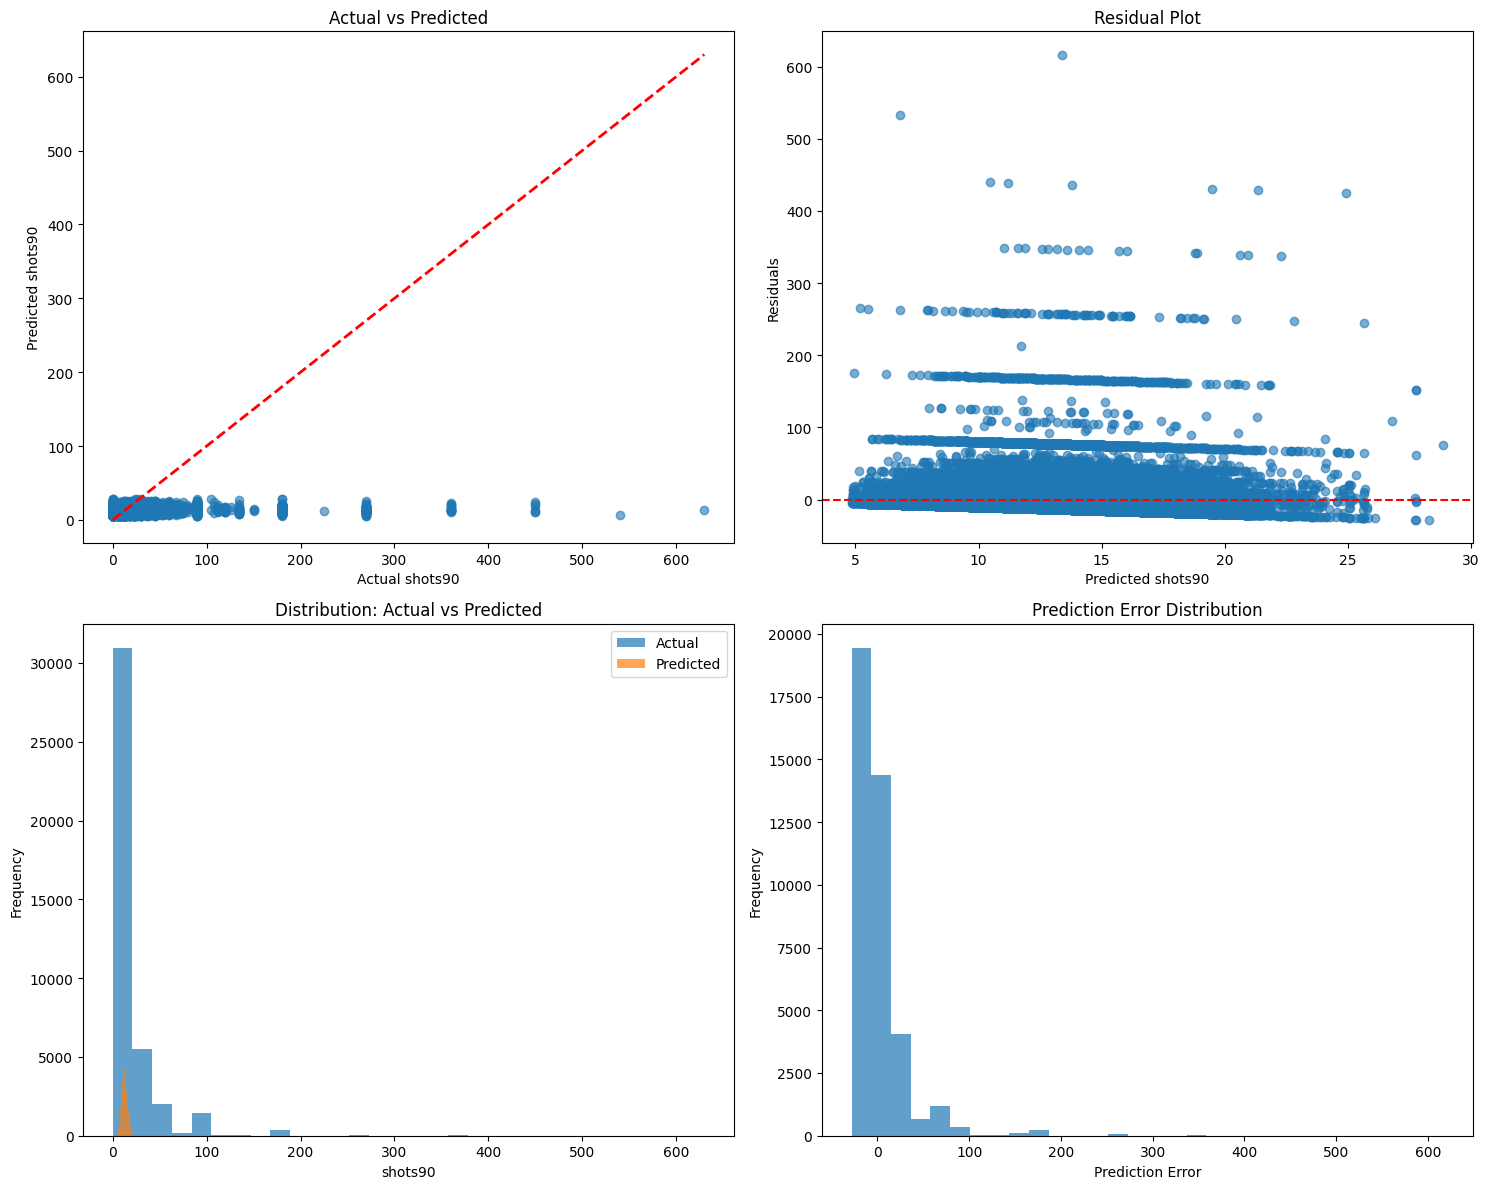

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
predictions = booster.predict(dtrain)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Actual vs Predicted scatter plot
axes[0,0].scatter(df_clean['shots90'], predictions, alpha=0.6)
axes[0,0].plot([df_clean['shots90'].min(), df_clean['shots90'].max()], 
               [df_clean['shots90'].min(), df_clean['shots90'].max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual shots90')
axes[0,0].set_ylabel('Predicted shots90')
axes[0,0].set_title('Actual vs Predicted')

# Residual plot
residuals = df_clean['shots90'] - predictions
axes[0,1].scatter(predictions, residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted shots90')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residual Plot')

# Distribution comparison
axes[1,0].hist(df_clean['shots90'], alpha=0.7, label='Actual', bins=30)
axes[1,0].hist(predictions, alpha=0.7, label='Predicted', bins=30)
axes[1,0].set_xlabel('shots90')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].set_title('Distribution: Actual vs Predicted')

# Error distribution
axes[1,1].hist(residuals, bins=30, alpha=0.7)
axes[1,1].set_xlabel('Prediction Error')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Prediction Error Distribution')

plt.tight_layout()
plt.show()

In [23]:
# Generate predictions
predictions = booster.predict(dtrain)

# Add predictions to your dataframe
df_clean['predicted_shots90'] = predictions

# Display results with actual vs predicted
results = df_clean[['shots90', 'predicted_shots90', 'ras90']].copy()
print("First 10 predictions:")
print(results.tail(20))

# Calculate some basic metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(df_clean['shots90'], predictions)
rmse = np.sqrt(mean_squared_error(df_clean['shots90'], predictions))

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

First 10 predictions:
         shots90  predicted_shots90      ras90
41924  90.000000           7.707950   8.511732
41925  15.000000           7.238843   8.042625
41926   0.000000           8.242686   9.046470
41927  18.000000           9.888937  10.692720
41928   0.000000           8.069181   8.872965
41929   0.000000           7.238811   8.042593
41930   0.000000           9.194587   9.998370
41931   0.000000           8.870219  10.524960
41932   0.000000           6.852711   8.265375
41933   0.000000           9.248751   8.617905
41934   0.000000          12.394565  10.608795
41935   8.181818          10.372282   9.741436
41936   0.000000           6.852711   8.265375
41937   0.000000          11.239641  10.608795
41938   6.000000           8.870219  10.524960
41939  12.857143           7.673635   9.328371
41940  18.000000           8.870219  10.524960
41941   6.000000           8.870219  10.524960
41942   0.000000           9.248751   8.617905
41943   0.000000           6.822129   

In [26]:
print("=== DATA DIAGNOSTICS ===")
print(f"Target (shots90) stats:")
print(f"  Mean: {y.mean():.2f}, Std: {y.std():.2f}")
print(f"  Min: {y.min():.2f}, 25th: {y.quantile(0.25):.2f}, 50th: {y.quantile(0.5):.2f}, 75th: {y.quantile(0.75):.2f}, Max: {y.max():.2f}")
print(f"RAS90 stats:")
print(f"  Mean: {df_clean['ras90'].mean():.2f}, Std: {df_clean['ras90'].std():.2f}")

=== DATA DIAGNOSTICS ===
Target (shots90) stats:
  Mean: 15.76, Std: 29.35
  Min: 0.00, 25th: 0.00, 50th: 6.00, 75th: 19.29, Max: 630.00
RAS90 stats:
  Mean: 12.47, Std: 2.48


In [27]:
# Look for potential data issues
print(f"Number of zeros in shots90: {(y == 0).sum()}")
print(f"Number of extreme values (>100): {(y > 100).sum()}")

# Check sample weights
print(f"Sample weights - Mean: {sample_weights.mean():.2f}, Max: {sample_weights.max():.2f}")

Number of zeros in shots90: 18716
Number of extreme values (>100): 500
Sample weights - Mean: 0.08, Max: 0.30
